# Try to do sentiment analysis using the textblob package in NLTK


In [42]:
import gzip
import json
import re
import os
from tqdm import tqdm
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import random
from textblob import TextBlob
import string
import numpy as np
from scipy.stats import entropy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
pd.options.display.float_format = '{:,}'.format

# download the NLTK stopwords and wordnet corpora
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
print("downloaded package wordnet")


downloaded package wordnet


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alexp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\alexp\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [22]:
# functin to load in the goodreads gzip files
# set head to take a subset of the reviews off the top
def load_data(file_name, head = 500):
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            data.append(d)
            
            # break if reaches the 100th line
            if (head is not None) and (count > head):
                break
    return data


In [29]:
DIR = 'data/'

reviews = load_data(os.path.join(DIR, 'goodreads_reviews_dedup.json.gz'), 10000)
reviews_df = pd.DataFrame(reviews)


In [20]:
# define a function to perform preprocessing on a single review text string with a loading bar
def preprocess_reviews(review_text):
    # define a progress bar with the total length of the review text
    with tqdm(total=len(review_text)) as pbar:
        # convert to lowercase
        review_text = review_text.lower()
        pbar.update(len(review_text))
        # remove punctuation
        review_text = review_text.translate(str.maketrans('', '', string.punctuation))
        pbar.update(len(string.punctuation))
        # tokenize into words
        words = word_tokenize(review_text)
        pbar.update(len(words))
        # remove stop words
        words = [word for word in words if word not in stopwords.words('english')]
        pbar.update(len(stopwords.words('english')))
        # lemmatize words
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
        pbar.update(len(words))
        # join the words back into a string
        review_text = ' '.join(words)
        pbar.update(len(words))
    return review_text

In [ ]:
# preprocess the review_text column of the DataFrame
reviews_df['review_text_preprocessed'] = reviews_df['review_text'].apply(preprocess_reviews)
print("reviews text preprocessed")


In [40]:
# new column for full review sentiment polarity score
reviews_df['sentiment_polarity'] = 0.0
# new column for sentence-wise sentiment polarity score
reviews_df['sentiment_polarity_sentence'] = ''

# calculate the sentiment polarity of each review using TextBlob
reviews_df['sentiment_polarity'] = reviews_df['review_text_preprocessed'].apply(lambda x: TextBlob(x).sentiment.polarity)
reviews_df['subjectivity'] = reviews_df['review_text_preprocessed'].apply(lambda x: TextBlob(x).sentiment.subjectivity if len(x.split()) >= 6 else None)


# calculate the absolute value of the sentiment polarity for each review
reviews_df['sentiment_polarity_abs'] = reviews_df['sentiment_polarity'].abs()


In [56]:
# add a column for review length
reviews_df['review_length'] = reviews_df['review_text'].apply(lambda x: len(x))


In [38]:
def plot_sentiment_polarity(reviews_df):            
    # calculate the sentiment polarity of each review using TextBlob, and exclude reviews that are shorter than 6 words
    reviews_df['sentiment_polarity'] = reviews_df['review_text_preprocessed'].apply(lambda x: TextBlob(x).sentiment.polarity if len(x.split()) >= 6 else None)

    # plot the sentiment polarity distribution
    sns.displot(reviews_df['sentiment_polarity'].dropna(), kde=True)
    plt.title('Sentiment Polarity Distribution')
    plt.xlabel('Sentiment Polarity')
    plt.show()
    plt.savefig("output/sentiment_polarity_1000")

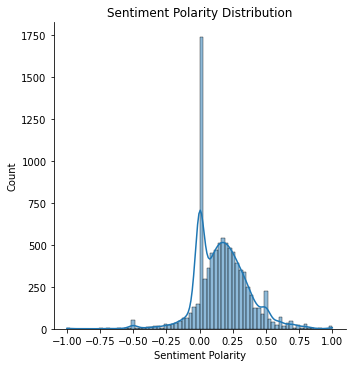

<Figure size 432x288 with 0 Axes>

In [39]:
plot_sentiment_polarity(reviews_df)

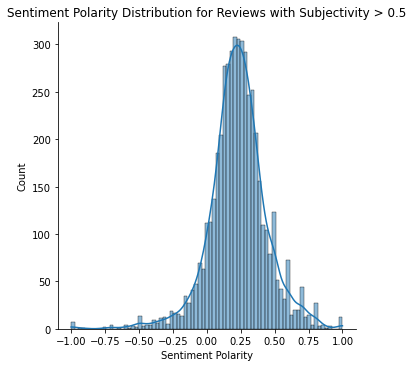

In [41]:
# plot the sentiment polarity distribution for reviews with subjectivity above 0.5
sns.displot(reviews_df[reviews_df['subjectivity'] > 0.5]['sentiment_polarity'].dropna(), kde=True)
plt.title('Sentiment Polarity Distribution for Reviews with Subjectivity > 0.5')
plt.xlabel('Sentiment Polarity')
plt.show()

In [43]:
def entropy_of_distribution(values):
    # compute the probability distribution of the input values
    prob = np.histogram(values, bins='auto', density=True)[0]
    # compute the entropy of the distribution using the scipy.stats.entropy function
    return entropy(prob)

In [45]:
# group the reviews by book
grouped_df = reviews_df.groupby('book_id')

# calculate the entropy and Gini coefficient of the sentiment polarity distribution for each book
entropy = grouped_df.apply(lambda x: entropy_of_distribution(x['sentiment_polarity']))
# add the entropy column to the reviews_df DataFrame
reviews_df['sentiment_entropy'] = reviews_df['book_id'].apply(lambda x: entropy[x])


C:\Users\alexp\AppData\Local\Temp\ipykernel_13736\2922722738.py:9: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * np.sum(cumsum_values) / (total_sum * len(values)) - (len(values) + 1) / len(values)


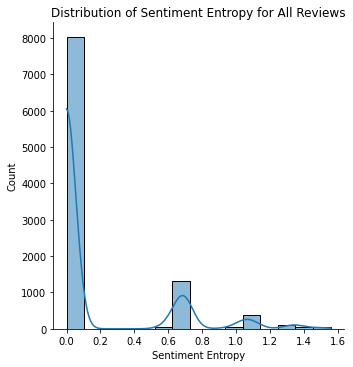

In [46]:
import seaborn as sns

# plot the distribution of entropy for all reviews
sns.displot(reviews_df['sentiment_entropy'].dropna(), kde=True)
plt.title('Distribution of Sentiment Entropy for All Reviews')
plt.xlabel('Sentiment Entropy')
plt.show()

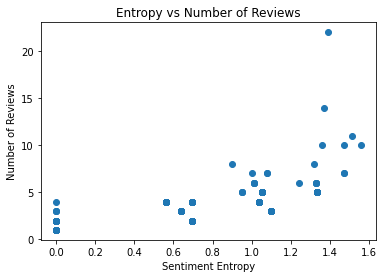

In [50]:
# group reviews by book and compute entropy and number of reviews
book_df = reviews_df.groupby('book_id').agg({'sentiment_entropy': 'mean', 'review_id': 'count'})

# plot entropy vs number of reviews
plt.scatter(book_df['sentiment_entropy'], book_df['review_id'])
plt.title('Entropy vs Number of Reviews')
plt.xlabel('Sentiment Entropy')
plt.ylabel('Number of Reviews')
plt.show()

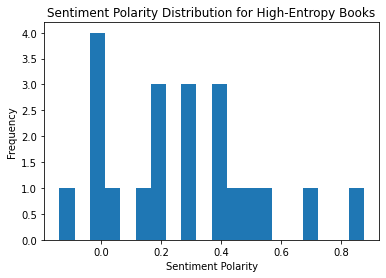

In [51]:
high_entropy_books = book_df[book_df['sentiment_entropy'] > 1.5]
# filter reviews to only include high-entropy books
high_entropy_reviews = reviews_df[reviews_df['book_id'].isin(high_entropy_books.index)]

# plot histogram of sentiment polarity scores
plt.hist(high_entropy_reviews['sentiment_polarity'], bins=20)
plt.title('Sentiment Polarity Distribution for High-Entropy Books')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()


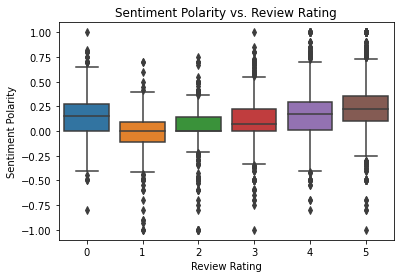

In [54]:
#sentiment vs book rating
sns.boxplot(x='rating', y='sentiment_polarity', data=reviews_df)
plt.title('Sentiment Polarity vs. Review Rating')
plt.xlabel('Review Rating')
plt.ylabel('Sentiment Polarity')
plt.show()

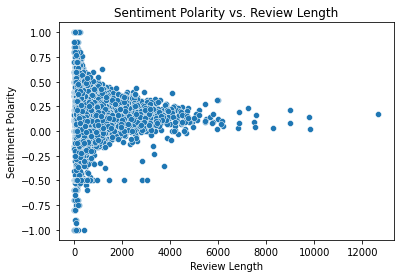

In [57]:
sns.scatterplot(x='review_length', y='sentiment_polarity', data=reviews_df)
plt.title('Sentiment Polarity vs. Review Length')
plt.xlabel('Review Length')
plt.ylabel('Sentiment Polarity')
plt.show()